# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
import pandas as pd
import numpy as np
import wfdb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Conv1D, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\mrall\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

## Download Dataset

In [3]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

In [4]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [5]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [6]:
invalid_beat = [
    "[", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+",
    "*", "D", "=", '"', "@", "?", "r", 
    "!", "T", "s"
]

normal_rhythms = ["N", "/"]                     # Normal beats, Paced beats

block_beats = ["L", "R", "B"]                   # Left, Right, Left or Right bundle 
                                                # branch block beats

escape_rhythms = ["e", "j", "V", "E", "n", "S"] # Atrial escape beat, Junctional escape
                                                # beat, Premature ventricular
                                                # contraction, Ventricular escape beat,
                                                # Supraventricular escape beat, Premature 
                                                # or ectopic supraventricular beat
                
premature_beats = ["a", "J", "A"]               # Aberrated atrial premature beat,
                                                # Junctional premature beat,  
                                                # Atrial premature contraction
        
fusion_beats = ["F"]                            # Fusion of ventricular and normal beat

unknown_beats = ["f", "Q"]                      # Fusion of paced and normal beat, 
                                                # Unclassifiable beat

## Processing dataset

In [7]:
def classify_beat(symbol):
    if symbol in normal_rhythms:
        return [1, 0, 0, 0, 0, 0]
    elif symbol in block_beats:
        return [0, 1, 0, 0, 0, 0]
    elif symbol in escape_rhythms:
        return [0, 0, 1, 0, 0, 0]
    elif symbol in premature_beats:
        return [0, 0, 0, 1, 0, 0]
    elif symbol in fusion_beats:
        return [0, 0, 0, 0, 1, 0]
    elif symbol in unknown_beats:
        return [0, 0, 0, 0, 0, 1] 

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
i = 0

for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        labels = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if labels is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(labels)

    subject_map.append({
        "subject": subject,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [10]:
subject_map = pd.DataFrame(subject_map)

In [11]:
train, test = train_test_split(subject_map, test_size=0.25, random_state=16)

In [12]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [13]:
x_train, y_train = build_dataset(train, all_sequences, all_labels)
x_test, y_test   = build_dataset(test, all_sequences, all_labels)

In [14]:
def get_labels(data):
    labels = []
    for i in data:
        if i[0] == 1:
            labels.append("Normal")
        elif i[1] == 1:
            labels.append("Block beats")
        elif i[2] == 1:
            labels.append("Escape rhythms")
        elif i[3] == 1:
            labels.append("Premature beats")
        elif i[4] == 1:
            labels.append("Fusion beats")
        elif i[5] == 1:
            labels.append("Unknown beats")
            
    return labels

In [15]:
def get_counts(labels):
    (unique, counts) = np.unique(labels, return_counts=True)
    frequencies = np.asarray((unique, np.round(counts*100 / (len(y_train) + len(y_test)), 2))).T
    return frequencies

In [16]:
train_labels = get_labels(y_train)
test_labels = get_labels(y_test)

print(f"Train labels:\n{get_counts(train_labels)}", f"Test labels\n{get_counts(test_labels)}", sep="\n\n")

Train labels:
[['Block beats' '12.18']
 ['Escape rhythms' '4.95']
 ['Fusion beats' '0.39']
 ['Normal' '52.51']
 ['Premature beats' '2.34']
 ['Unknown beats' '0.93']]

Test labels
[['Block beats' '1.83']
 ['Escape rhythms' '1.89']
 ['Fusion beats' '0.35']
 ['Normal' '22.44']
 ['Premature beats' '0.2']
 ['Unknown beats' '0.0']]


# Training the model

In [35]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(8, 20, activation="relu", input_shape=(sequence_size, n_features), kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(8, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(8, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(8, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(8, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))
model.add(MaxPooling1D(pool_size=2))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(16, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(16, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(16, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(16, 20, activation="relu", kernel_regularizer=regularizers.l2(0.07)))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.07)))

model.add(Dropout(0.5))
model.add(Dense(6, activation="softmax", name="output"))

optimizer = Adam(lr=0.00007)


model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 2141, 8)           168       
_________________________________________________________________
batch_normalization_35 (Batc (None, 2141, 8)           32        
_________________________________________________________________
dropout_38 (Dropout)         (None, 2141, 8)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2122, 8)           1288      
_________________________________________________________________
batch_normalization_36 (Batc (None, 2122, 8)           32        
_________________________________________________________________
dropout_39 (Dropout)         (None, 2122, 8)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 2103, 8)          

In [36]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback], verbose = 2)

Epoch 1/100
500/500 - 32s - loss: 10.5947 - accuracy: 0.3014 - val_loss: 9.2127 - val_accuracy: 0.8509
Epoch 2/100
500/500 - 26s - loss: 8.3591 - accuracy: 0.4236 - val_loss: 7.1827 - val_accuracy: 0.8509
Epoch 3/100
500/500 - 26s - loss: 6.3864 - accuracy: 0.5355 - val_loss: 5.5023 - val_accuracy: 0.8509
Epoch 4/100
500/500 - 26s - loss: 4.7599 - accuracy: 0.6443 - val_loss: 3.9849 - val_accuracy: 0.8508
Epoch 5/100
500/500 - 27s - loss: 3.4966 - accuracy: 0.7194 - val_loss: 2.7676 - val_accuracy: 0.8509
Epoch 6/100
500/500 - 27s - loss: 2.5910 - accuracy: 0.7643 - val_loss: 2.0910 - val_accuracy: 0.8499
Epoch 7/100
500/500 - 27s - loss: 1.9423 - accuracy: 0.8042 - val_loss: 1.5817 - val_accuracy: 0.8498
Epoch 8/100
500/500 - 27s - loss: 1.4938 - accuracy: 0.8339 - val_loss: 1.2951 - val_accuracy: 0.8492
Epoch 9/100
500/500 - 27s - loss: 1.1934 - accuracy: 0.8481 - val_loss: 1.0614 - val_accuracy: 0.8476
Epoch 10/100
500/500 - 26s - loss: 0.9931 - accuracy: 0.8587 - val_loss: 0.8755 -

911/911 [==============================] - 8s 8ms/step - loss: 0.4168 - accuracy: 0.9027





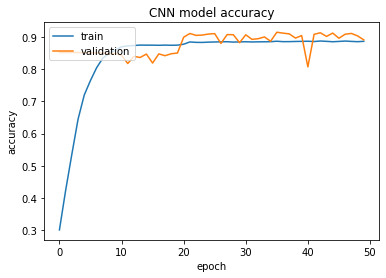

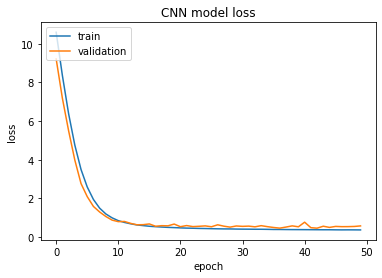

In [37]:
model.evaluate(x_test, y_test)
print("\n\n")

# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("\n\n")

# summarize history for loss   
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model saving

In [ ]:
import os
os.remove("C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5")
model.save('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5')

# Model loading

In [24]:
from tensorflow.keras.models import load_model
new_model = load_model('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5')

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
from keras_visualizer import visualizer

visualizer(model, format='png', view=True)

Using TensorFlow backend.


ValueError: Keras Visualizer: Layer not supported for visualizing